In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from utilities3 import LpLoss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde

Using backend: pytorch



In [3]:
# Full Dataset Generation
ndata = 100

X = 1
dx = 0.01
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx)
T = 2
dt = 0.0001
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt)

In [5]:
# Parameters
epochs =300
ntrain = 900
ntest = 100
batch_size = 100
gamma = 0.5
learning_rate = 0.001
step_size= 50
modes=12
width=32

X = 1
dx = 0.01
nx = int(round(X/dx))
grid = np.linspace(0, X, nx, dtype=np.float32).reshape(nx, 1)
grid = np.concatenate((grid, grid))
grid = torch.from_numpy(np.array(grid, dtype=np.float32)).cuda()

In [ ]:
def solveControl(u, kernel):
    res = 0
    for i in range(nx):
        res += kernel[i]*u[i]
    return res*dx

def solveBetaFunction(x, gamma):
    beta = np.zeros(nx)
    for idx, val in enumerate(x):
        beta[idx] = 5*math.cos(gamma*math.acos(val))
    return beta
        
def solveKernelFunction(beta):
    kappa = np.zeros(nx)
    for i in range(0, nx):
        kernelIntegral = 0
        for j in range(0, i):
            kernelIntegral += (kappa[i-j]*beta[j])*dx
        kappa[i] = kernelIntegral  - beta[i]
    return np.flip(kappa)

In [9]:
# Dataset generation. Uncomment if you want to build your own datasets.


# Create random u of both large magnitude and small magnitude
# uDataArr = []
# for i in range(400):
#     u = np.random.uniform(-10, 15, 100)
#     uDataArr.append(u)       
# for i in range(100):
#     u = np.random.uniform(-1, 1, 100)
#     uDataArr.append(u)

# inpArr = []
# outArr = []
# betaArr = []
# for i in range(100):
#     beta = solveBetaFunction(np.linspace(0, 1, 100),np.random.uniform(2, 6))
#     betaArr.append(beta)
# kernel = solveKernelFunction(beta)
# for beta in betaArr:
#     for u in uDataArr:
#         control = solveControl(u,solveKernelFunction(beta))
#         res = []
#         for i in range(len(u)):
#             res.append((u[i]))
#         for i in range(len(u)):
#             res.append(beta[i])
#         inpArr.append(res)
#         outArr.append(control)
        
# np.savetxt("x.dat", inpArr)
# np.savetxt("y.dat", outArr)

(100,)


In [10]:
# Create train/test splits
inpArr = np.loadtxt("x.dat", dtype=np.float32)
outArr = np.loadtxt("y.dat", dtype=np.float32)
x = np.array(inpArr, dtype=np.float32)
y = np.array(outArr, dtype=np.float32)

y = y.reshape(y.shape[0],1 )
x = x.reshape(x.shape[0], x.shape[1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [11]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [15]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show in 2D problem
dim_x = 1
m = 200
branch = [m, 256, 256]
trunk = [dim_x, 128, 256]
activation = "relu"
kernel = "Glorot normal"

class DeepONetModified(nn.Module):
    def __init__(self, branch, trunk, activation, kernel, projection):
        super(DeepONetModified, self).__init__()
        self.net1 = dde.nn.DeepONetCartesianProd(branch, trunk, activation, kernel).cuda()
        self.fc1 = nn.Linear(200, 200)
        self.fc2 = nn.Linear(200, 200)
        self.net2 = dde.nn.DeepONetCartesianProd(branch, trunk, activation, kernel).cuda()
        self.fc3 = nn.Linear(200,128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, projection)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x, grid = x[0], x[1]
        x = self.net1((x, grid))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.net2((x, grid))
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x
       
projection  = 1
model = DeepONetModified(branch, trunk, activation, kernel, projection)
print(count_params(model))

415507


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [232]:
loss = nn.MSELoss()
train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model((x, grid))
        lp = loss(out.view(batch_size, -1), y.view(batch_size, -1))
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            out = model((x, grid))
            test_loss += loss(out.view(batch_size), y.view(batch_size)).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, np.mean(train_lossArr[-50:]), np.mean(test_lossArr[-50:]))

0 2.194884012977127 89.57528659820557 36.47883808135986
50 2.2731421290081926 2.8876215182893805 2.5645233441412447
100 2.2943248030205723 0.1716926338429252 0.2569454128071666
150 1.8676199820183683 0.04633449824446191 0.07423691864274443
200 1.8651808790164068 0.015611791069898755 0.050227550381049514
250 1.8560470290249214 0.007213492628864738 0.0333851928865537


Avg Epoch Time: 1.9410686623094564
Final Testing Loss: 1.4428646825253963
Final Training Loss: 1.613239831989631


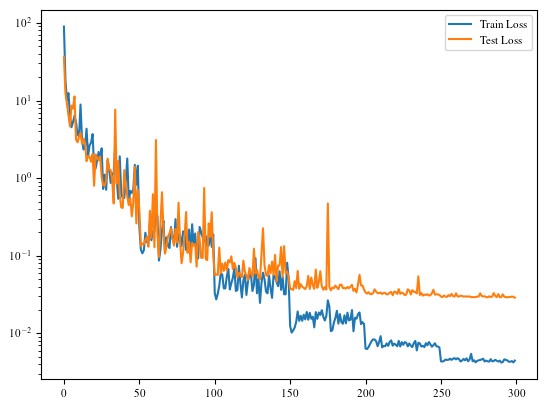

In [233]:
# Display Model Details
plt.figure()
plt.plot(train_lossArr, label="Train Loss")
plt.plot(test_lossArr, label="Test Loss")
plt.yscale("log")
plt.legend()

testLoss = 0
trainLoss = 0
with torch.no_grad():
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        out = out.reshape((out.shape[0], out.shape[1]))
        trainLoss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
        
    for x, y in testData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        out = out.reshape((out.shape[0], out.shape[1]))
        testLoss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
    
    
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
print("Final Testing Loss:", testLoss)
print("Final Training Loss:", trainLoss)

In [19]:
# Solves the PDE for a single instance of beta and kappa. Returns solution and control values
def solvePDE(beta, kappa, init_condition, x, t, controlFunc, param):
    u = np.zeros((len(t), len(x)))
    U = np.zeros(len(t))

    # Set intial condition
    for i in range(len(x)):
        u[0][i] = init_condition[i]
    print("Solving PDE... Timesteps Needed:", len(t))
    for i in range(1, len(t)):
        if i%int(len(t)/2) == 0:
            print("Completed:", i, "/", len(t))
        u[i][-1] = controlFunc(u[i-1], param)
        U[i] = u[i][-1]
        for j in range(0, nx-1):
            u[i][j] = u[i-1][j] + dt*((u[i-1][j+1] - u[i-1][j])/dx + beta[j]*u[i-1][0])
    
    return u, U

# PDE L2 Error
def getPDEl2(u, uhat):
    pdeError = np.zeros(nt-1)
    for i in range(1, nt):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error*0.01)
        pdeError[i-1] = error
    return pdeError

In [20]:
# Get 20 instances of test data. 
for x, y in testData:
    xinst, yinst = x.cuda(), y.cuda()
    out = model((xinst, grid))
    
nx = 100
def solveBetaFunction(x, gamma):
    beta = np.zeros(nx)
    for idx, val in enumerate(x):
        beta[idx] = 5*math.cos(gamma*math.acos(val))
    return beta

def solveKernelFunction(beta):
    kappa = np.zeros(nx)
    for i in range(0, nx):
        kernelIntegral = 0
        for j in range(0, i):
            kernelIntegral += (kappa[i-j]*beta[j])*dx
        kappa[i] = kernelIntegral  - beta[i]
    return np.flip(kappa)

def solveModelControl(u, beta):
    res = []
    for i in range(len(beta)):
        res.append(u[i])
    for i in range(len(beta)):
        res.append(beta[i])
    res = torch.from_numpy(np.array(res, dtype=np.float32).reshape(1, len(res))).cuda()
    out = model((res, grid))
    return out[0][0].cpu().detach().numpy() 

def openLoop(_, _a):
    return 0

T = 2
dt = 0.0001
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt)

beta = solveBetaFunction(spatial,3)  
kernel = solveKernelFunction(beta)

# Decide to load model pretrained or use model. To use pretrained uncomment this line. To use trained, 
#comment this line
#model.load_state_dict(torch.load('betautoUTorchModel'))

# Showcase PDE Difference
init_cond = np.zeros(101)
init_cond.fill(10)
uhat, Uhat = solvePDE(beta, kernel, init_cond, spatial, temporal, solveModelControl, beta)
u, U = solvePDE(beta, kernel, init_cond, spatial, temporal, solveControl, kernel)

Solving PDE... Timesteps Needed: 20000
Completed: 10000 / 20000
Solving PDE... Timesteps Needed: 20000
Completed: 10000 / 20000


In [21]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

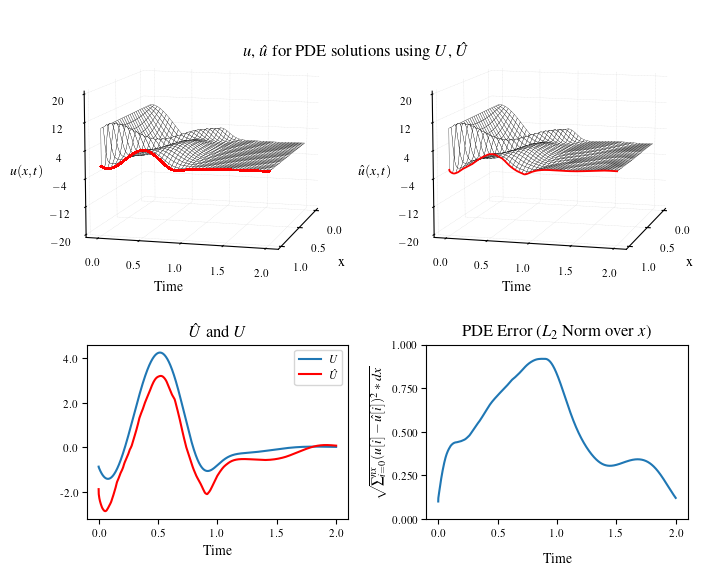

In [23]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (2, 2), height_add=1))
plt.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.suptitle(r"$u$, $\hat{u}$ for PDE solutions using $U$, $\hat{U}$")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, u, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(nt)
vals = (u.transpose())[-1] 
zticks = np.linspace(-20, 20, 6)
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$u(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].plot_surface(meshx, mesht, uhat, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uhat.transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$\hat{u}(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_zticks(zticks)
ax[0].set_zticks(zticks)

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
yticks = np.linspace(0, 1, 5)
subfig = subfigs[1]
ax = subfig.subplots(nrows=1, ncols=2)
subfig.subplots_adjust(left=0.12, bottom=0.2, right=.97, top=0.85, wspace=0.3, hspace=0.1)
ax[1].plot(temporal[1:], getPDEl2(u, uhat))
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[1].set_xlabel("Time", labelpad=10)
ax[1].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$")
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax[1].title.set_text(r"PDE Error ($L_2$ Norm over $x$)")
ax[1].set_yticks(yticks)

control = (u.transpose())[-1]
chat = (uhat.transpose())[-1]
ax[0].plot(temporal[1:], control[1:], label=r"$U$")   
ax[0].plot(temporal[1:], chat[1:], label=r"$\hat{U}$", color="red")
ax[0].legend()
ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[0].set_xlabel("Time")
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].title.set_text(r"$\hat{U}$ and $U$")